# **K-Pop가사 생성모델 만들기(미세튜닝)**


---


- 💡 **NOTE**
    - 이 노트북의 코드를 실행하려면 GPU를 사용하는 것이 좋습니다. 구글 코랩에서는 **런타임 > 런타임 유형 변경 > 하드웨어 가속기 > T4 GPU**를 선택하세요.


---

- **목표**
    - 한국어를 잘하는 경량화 모델(예: KoGPT2 또는 Polyglot-Ko 5.8B 등)을 가져와,  
    - K-pop 가사 데이터셋으로 추가 학습(**Fine-tuning**)시켜
    - **K-Pop가사 생성모델 만들기**
- **데이터셋**
    - **EX3exp / Kpop-lyric-datasets** (GitHub)
    - https://github.com/EX3exp/Kpop-lyric-datasets



---



In [1]:
%%capture
!pip install transformers accelerate tokenizers datasets safetensors
!pip install -q transformers peft trl bitsandbytes datasets accelerate

In [2]:
# 한글 폰트 설치
!apt-get install -y fonts-nanum > /dev/null

# Matplotlib에 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)  # 마이너스 기호 깨짐 방지

# 폰트가 잘 등록되었는지 확인
print("✅ 사용 가능한 폰트 예시:")
print(sorted([f.name for f in fm.fontManager.ttflist if "Nanum" in f.name]))


✅ 사용 가능한 폰트 예시:
[]




---



## **K-pop 가사 데이터셋을 이용한 미세튜닝**

### **1단계: 깃허브에서 K-pop 가사 데이터셋 다운로드 및 전처리**

In [3]:
# 기존에 있던 폴더강제  삭제하기
!rm -rf /content/Kpop-lyric-datasets

In [4]:
# 1. 깃허브 저장소 복제 (데이터 다운로드)
!git clone https://github.com/EX3exp/Kpop-lyric-datasets.git

# 2. 필요한 라이브러리 설치
# datasets: 허깅페이스의 데이터셋 라이브러리
# transformers: 모델 및 토크나이저 라이브러리
# accelerate: 학습 가속화
!pip install datasets transformers accelerate

Cloning into 'Kpop-lyric-datasets'...
remote: Enumerating objects: 26227, done.
remote: Counting objects: 100% (26227/26227), done.
remote: Compressing objects: 100% (25585/25585), done.
remote: Total 26227 (delta 656), reused 26196 (delta 639), pack-reused 0 (from 0)
Receiving objects: 100% (26227/26227), 24.97 MiB | 16.50 MiB/s, done.
Resolving deltas: 100% (656/656), done.
Updating files: 100% (25885/25885), done.


In [5]:
# ✅ 이 셀을 "항상" 최상단(모델/라이브러리 import 전에) 실행하세요.
import os
os.environ["WANDB_DISABLED"] = "true"   # wandb 완전 비활성화
os.environ["WANDB_MODE"] = "disabled"   # (중복 안전장치)
os.environ["WANDB_SILENT"] = "true"    # 로그도 조용히

import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)



---



###1. 데이터 만들기
-  2021년 이후 데이터셋만 추출하기


In [6]:
import os
import json # .json 파일을 파싱(parsing)하기 위해 내장 라이브러리 import
from glob import glob
import re   # 정규표현식 라이브러리 추가

# 3. 정확한 JSON 파일 경로 탐색
data_path = "Kpop-lyric-datasets/melon/monthly-chart"
search_pattern = os.path.join(data_path, "*", "*", "*.json")
all_json_files = glob(search_pattern)

print(f"발견된 총 JSON 파일 개수: {len(all_json_files)}개")

if not all_json_files:
    print("!!! 오류: JSON 파일을 찾지 못했습니다. git clone이 성공했는지, 경로가 올바른지 확인하세요.")


# 4. JSON 파일을 '단일 딕셔너리'로 간주하고 가사 추출
train_file_path = "kpop_lyrics_train1.txt"
total_lyrics_count = 0
processed_files_count = 0 # (추가) 2020년 이후 처리된 파일 카운트

# 파일 경로에서 연도를 추출하기 위한 정규표현식 컴파일
# 'melon-' 뒤에 나오는 4자리 숫자(\d{4})를 찾습니다.
year_pattern = re.compile(r'melon-(\d{4})')

with open(train_file_path, "w", encoding="utf-8") as train_file:
    for file_path in all_json_files: # 각 JSON 파일을 순회

        # --- 연도 필터링 로직 ---
        year_match = year_pattern.search(file_path)

        if not year_match:
            # 'melon-YYYY' 패턴이 파일 경로에 없으면 건너뜁니다.
            continue

        # 정규표현식으로 찾은 연도(문자열)를 정수(int)로 변환
        year = int(year_match.group(1))

        # 2021년 미만 데이터는 건너뜁니다.
        if year < 2021:
            continue
        # --------------------------------

        # (2021년 이상인 파일만 처리)
        processed_files_count += 1

        try:
            with open(file_path, "r", encoding="utf-8") as f:
                # JSON 파일 1개를 딕셔너리(song_data)로 바로 로드합니다.
                song_data = json.load(f)

                # 1. 'lyrics' 객체를 song_data에서 직접 가져옵니다.
                lyrics_object = song_data.get("lyrics")

                # 2. lyrics_object가 존재하고, 딕셔너리 형태일 경우에만 'lines' 리스트를 찾습니다.
                if lyrics_object and isinstance(lyrics_object, dict):
                    lines_list = lyrics_object.get("lines")

                    # 3. lines_list가 존재하고, 리스트 형태일 경우에만 가사를 합칩니다.
                    if lines_list and isinstance(lines_list, list):
                        full_lyrics = "\n".join(lines_list).strip()

                        if full_lyrics:
                            train_file.write(full_lyrics + "\n\n<|endoftext|>\n\n")
                            total_lyrics_count += 1

        except json.JSONDecodeError:
            print(f"JSON 파싱 오류: {file_path} (파일이 손상되었을 수 있습니다)")
        except AttributeError as e: # 'str' object has no attribute 'get' 오류 발생 시
             print(f"!!! 데이터 구조 오류 ({file_path}): {e}. JSON 파일이 예상과 다른 구조일 수 있습니다.")
        except Exception as e:
            print(f"파일 처리 중 알 수 없는 오류 ({file_path}): {e}")

print(f"'{train_file_path}' 파일 생성 완료!")
print(f"--- (필터링 적용) 2021년 이후 데이터만 처리 ---")
print(f"처리된 파일 개수: {processed_files_count}개 (전체: {len(all_json_files)}개 중)")
print(f"총 {total_lyrics_count}개의 가사를 성공적으로 추출하여 파일에 저장했습니다.")


발견된 총 JSON 파일 개수: 25876개
'kpop_lyrics_train1.txt' 파일 생성 완료!
--- (필터링 적용) 2021년 이후 데이터만 처리 ---
처리된 파일 개수: 3300개 (전체: 25876개 중)
총 3294개의 가사를 성공적으로 추출하여 파일에 저장했습니다.




---



###2. 추가 데이터 만들기
-  2018년 데이터셋만 추출하기


In [7]:
import os
import json # .json 파일을 파싱(parsing)하기 위해 내장 라이브러리 import
from glob import glob
import re   # 정규표현식 라이브러리 추가

# 3. 정확한 JSON 파일 경로 탐색
data_path = "Kpop-lyric-datasets/melon/monthly-chart"
search_pattern = os.path.join(data_path, "*", "*", "*.json")
all_json_files = glob(search_pattern)

print(f"발견된 총 JSON 파일 개수: {len(all_json_files)}개")

if not all_json_files:
    print("!!! 오류: JSON 파일을 찾지 못했습니다. git clone이 성공했는지, 경로가 올바른지 확인하세요.")


# 4. JSON 파일을 '단일 딕셔너리'로 간주하고 가사 추출
train_file_path = "kpop_lyrics_train2.txt"
total_lyrics_count = 0
processed_files_count = 0 # (추가) 2020년 이후 처리된 파일 카운트

# 파일 경로에서 연도를 추출하기 위한 정규표현식 컴파일
# 'melon-' 뒤에 나오는 4자리 숫자(\d{4})를 찾습니다.
year_pattern = re.compile(r'melon-(\d{4})')

with open(train_file_path, "w", encoding="utf-8") as train_file:
    for file_path in all_json_files: # 각 JSON 파일을 순회

        # --- 연도 필터링 로직 ---
        year_match = year_pattern.search(file_path)

        if not year_match:
            # 'melon-YYYY' 패턴이 파일 경로에 없으면 건너뜁니다.
            continue

        # 정규표현식으로 찾은 연도(문자열)를 정수(int)로 변환
        year = int(year_match.group(1))

        # 2018년 데이터만 가져오기.
        if year >2019 or year < 2017:
            continue
        # --------------------------------

        # (2020년 이상인 파일만 처리)
        processed_files_count += 1

        try:
            with open(file_path, "r", encoding="utf-8") as f:
                # JSON 파일 1개를 딕셔너리(song_data)로 바로 로드합니다.
                song_data = json.load(f)

                # 1. 'lyrics' 객체를 song_data에서 직접 가져옵니다.
                lyrics_object = song_data.get("lyrics")

                # 2. lyrics_object가 존재하고, 딕셔너리 형태일 경우에만 'lines' 리스트를 찾습니다.
                if lyrics_object and isinstance(lyrics_object, dict):
                    lines_list = lyrics_object.get("lines")

                    # 3. lines_list가 존재하고, 리스트 형태일 경우에만 가사를 합칩니다.
                    if lines_list and isinstance(lines_list, list):
                        full_lyrics = "\n".join(lines_list).strip()

                        if full_lyrics:
                            train_file.write(full_lyrics + "\n\n<|endoftext|>\n\n")
                            total_lyrics_count += 1

        except json.JSONDecodeError:
            print(f"JSON 파싱 오류: {file_path} (파일이 손상되었을 수 있습니다)")
        except AttributeError as e: # 'str' object has no attribute 'get' 오류 발생 시
             print(f"!!! 데이터 구조 오류 ({file_path}): {e}. JSON 파일이 예상과 다른 구조일 수 있습니다.")
        except Exception as e:
            print(f"파일 처리 중 알 수 없는 오류 ({file_path}): {e}")

print(f"'{train_file_path}' 파일 생성 완료!")
print(f"--- (필터링 적용) 2018년 데이터만 처리 ---")
print(f"처리된 파일 개수: {processed_files_count}개 (전체: {len(all_json_files)}개 중)")
print(f"총 {total_lyrics_count}개의 가사를 성공적으로 추출하여 파일에 저장했습니다.")


발견된 총 JSON 파일 개수: 25876개
'kpop_lyrics_train2.txt' 파일 생성 완료!
--- (필터링 적용) 2018년 데이터만 처리 ---
처리된 파일 개수: 3600개 (전체: 25876개 중)
총 3560개의 가사를 성공적으로 추출하여 파일에 저장했습니다.




---



### **K-pop 가사 데이터셋으로 KoGPT2 모델 파인튜닝**

In [8]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TextDataset,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)

# 1. 파인튜닝할 기반 모델 및 토크나이저 선택
BASE_MODEL = "skt/KoGPT2-base-v2"

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL,
    bos_token='<s>', # 문장 시작
    eos_token='</s>', # 문장 끝
    unk_token='<unk>',
    pad_token='<pad>',
    mask_token='<mask>')

model = AutoModelForCausalLM.from_pretrained(BASE_MODEL)
model.resize_token_embeddings(len(tokenizer)) # 토크나이저에 맞게 모델 임베딩 크기 조절

# 2. 학습 데이터셋 로드
# 우리가 1단계에서 만든 kpop_lyrics_train.txt 파일을 사용합니다.
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=train_file_path,  # kpop_lyrics_train.txt
    block_size=128              # 메모리에 맞게 블록 크기 조절 (128~256)
)

# 3. 데이터 콜레이터 설정 (배치 생성)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # Masked Language Model (BERT)가 아닌 Causal LM (GPT) 방식
)

# 4. 학습 설정 (TrainingArguments)
# 파인튜닝된 모델이 저장될 경로
output_dir = "./kpop-kogpt2-finetuned"

training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=3,     # 에포크 수 (3~5 정도가 적당)
    per_device_train_batch_size=4,  # Colab T4 메모리에 맞게 배치 크기 (4 또는 8)
    save_steps=10_000,      # (예제라 저장 스텝은 크게 잡음)
    save_total_limit=2,
    logging_steps=100,      # 100 스텝마다 로그 출력
    fp16=True, # T4 GPU에서 학습 속도 향상을 위해 16비트 사용
)

# 5. 트레이너(Trainer) 생성 및 학습 시작
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

print("=== K-pop 가사 데이터로 모델 파인튜닝을 시작합니다 ===")
trainer.train()
print("=== 파인튜닝 완료! ===")

# 6. 학습된 모델 저장
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"파인튜닝된 K-pop 모델이 '{output_dir}'에 저장되었습니다.")

# 파인튜닝된 K-pop 모델이 './kpop-kogpt2-finetuned'에 저장되었습니다.

config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


=== K-pop 가사 데이터로 모델 파인튜닝을 시작합니다 ===


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,3.625600
200,3.410800
300,3.193600
400,3.028200
500,3.031400
600,2.968700
700,2.794200
800,2.660200
900,2.663200
1000,2.594900


=== 파인튜닝 완료! ===
파인튜닝된 K-pop 모델이 './kpop-kogpt2-finetuned'에 저장되었습니다.




---



### KoGPT2 모델 파인튜닝 추가 학습 시키기

In [9]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

# 1️⃣ 이전에 학습한 모델 불러오기
model_path = "./kpop-kogpt2-finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path)

# 2️⃣ 새 데이터셋 로드
train_file_path_new = "kpop_lyrics_train1.txt"
train_dataset_new = TextDataset(
    tokenizer=tokenizer,
    file_path=train_file_path_new,
    block_size=128
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# 3️⃣ 새로운 학습 설정
output_dir_new = "./kpop-kogpt2-finetuned-v2"

training_args_new = TrainingArguments(
    output_dir=output_dir_new,
    overwrite_output_dir=True,
    num_train_epochs=2,        # 기존 학습보다 짧게
    per_device_train_batch_size=4,
    logging_steps=100,
    save_steps=2000,
    fp16=True,
)

# 4️⃣ Trainer 재정의
trainer_new = Trainer(
    model=model,
    args=training_args_new,
    data_collator=data_collator,
    train_dataset=train_dataset_new,
)

print("=== 새로운 데이터로 추가 파인튜닝 시작 ===")
trainer_new.train()
print("=== 추가 파인튜닝 완료 ===")

# 5️⃣ 모델 저장
model.save_pretrained(output_dir_new)
tokenizer.save_pretrained(output_dir_new)
print(f"추가 튜닝된 모델이 '{output_dir_new}'에 저장되었습니다.")


/usr/local/lib/python3.12/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


=== 새로운 데이터로 추가 파인튜닝 시작 ===


Step,Training Loss
100,3.111600
200,2.974300
300,2.744000
400,2.524200
500,2.476700
600,2.212600
700,2.294000
800,2.068900
900,1.976000
1000,1.926700


=== 추가 파인튜닝 완료 ===
추가 튜닝된 모델이 './kpop-kogpt2-finetuned-v2'에 저장되었습니다.




---



### 프롬프트 작성하기.

In [10]:
from IPython.display import display, clear_output
import ipywidgets as widgets

# 🎯 프롬프트를 담을 리스트
prompts = []
max_prompts = 5  # 입력할 프롬프트 개수

# 입력창과 버튼 구성
prompt_input = widgets.Text(
    placeholder="프롬프트를 입력하세요 (예: 오늘 밤 너와 나)",
    description="🎵 프롬프트:",
    layout=widgets.Layout(width="80%")
)

add_button = widgets.Button(description="➕ 추가", button_style="info")
status_output = widgets.Output()

# 버튼 클릭 시 호출되는 함수
def add_prompt(_):
    text = prompt_input.value.strip()
    if text:
        prompts.append(text)
        prompt_input.value = ""
        with status_output:
            clear_output(wait=True)
            print(f"✅ 추가됨: {text}")
            print(f"📦 현재 프롬프트 개수: {len(prompts)}/{max_prompts}")
        if len(prompts) >= max_prompts:
            with status_output:
                print("🎯 5개의 프롬프트 입력 완료!")
            prompt_input.disabled = True
            add_button.disabled = True
            print("최종 프롬프트 리스트:", prompts)

add_button.on_click(add_prompt)

display(prompt_input, add_button, status_output)


Text(value='', description='🎵 프롬프트:', layout=Layout(width='80%'), placeholder='프롬프트를 입력하세요 (예: 오늘 밤 너와 나)')

Button(button_style='info', description='➕ 추가', style=ButtonStyle())

Output()

최종 프롬프트 리스트: ['오늘 밤 너와 나', '사랑', '바닷가에서', '해변에서', '함께하는']


### DPO  적용 모델 만들기 (Direct Preference Optimization)

In [11]:
!pip install ipywidgets transformers torch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.8 MB/s eta 0:00:00


In [12]:
from IPython.display import display, clear_output, HTML
import ipywidgets as widgets
import torch, json
from transformers import pipeline

# 1️⃣ 모델 로드
finetuned_model_path = "./kpop-kogpt2-finetuned-v2"

generator = pipeline(
    "text-generation",
    model=finetuned_model_path,
    tokenizer=finetuned_model_path,
    device=0 if torch.cuda.is_available() else -1
)



# 3️⃣ 결과 저장용 리스트
results = []
output_file = "kpop_preference_dataset.jsonl"

# 4️⃣ 인터랙티브 선택 함수
def run_prompt_selection(index=0):
    if index >= len(prompts):
        clear_output(wait=True)
        print("✅ 모든 선호도 수집 완료!")
        # JSONL로 저장
        with open(output_file, "w", encoding="utf-8") as f:
            for item in results:
                f.write(json.dumps(item, ensure_ascii=False) + "\n")
        print(f"💾 '{output_file}' 파일로 저장되었습니다.")
        return

    prompt = prompts[index]
    clear_output(wait=True)
    display(HTML(f"<h3>🎵 프롬프트: <span style='color:#007bff'>{prompt}</span></h3>"))

    # 두 가지 가사 후보 생성
    outputs = generator(
        prompt,
        num_return_sequences=2,
        min_new_tokens=50,
        max_new_tokens=100,
        do_sample=True,
        top_k=50,
        top_p=0.9,
        no_repeat_ngram_size=2,
        eos_token_id=tokenizer.eos_token_id
        )

    text1 = outputs[0]["generated_text"].replace("<|endoftext|>", "").strip()
    text2 = outputs[1]["generated_text"].replace("<|endoftext|>", "").strip()

    # --- 두 가사를 좌우로 나란히 출력 ---
    style_block = """
    <style>
        .lyrics-box {
            width: 48%;
            padding: 10px;
            border: 2px solid #ccc;
            border-radius: 10px;
            background-color: #000000;
            white-space: pre-wrap;
            overflow-y: auto;
            height: 250px;
        }
        .lyrics-container {
            display: flex;
            justify-content: space-between;
            gap: 10px;
            margin-bottom: 10px;
        }
    </style>
    """

    html_content = f"""
    {style_block}
    <div class='lyrics-container'>
        <div class='lyrics-box'><b>🎶 1번 가사</b><br><hr>{text1}</div>
        <div class='lyrics-box'><b>🎵 2번 가사</b><br><hr>{text2}</div>
    </div>
    """
    display(HTML(html_content))

    # --- 버튼 UI ---
    btn1 = widgets.Button(description="❤️ 1번이 좋아요", button_style='success', layout=widgets.Layout(width='40%'))
    btn2 = widgets.Button(description="💔 2번이 좋아요", button_style='info', layout=widgets.Layout(width='40%'))

    box = widgets.HBox([btn1, btn2], layout=widgets.Layout(justify_content='center', margin='10px 0 20px 0'))
    display(box)

    def handle_choice(choice):
        if choice == 1:
            chosen, rejected = text1, text2
        else:
            chosen, rejected = text2, text1

        results.append({
            "prompt": prompt,
            "chosen": chosen,
            "rejected": rejected
        })
        run_prompt_selection(index + 1)

    btn1.on_click(lambda _: handle_choice(1))
    btn2.on_click(lambda _: handle_choice(2))

# 5️⃣ 실행
run_prompt_selection()


✅ 모든 선호도 수집 완료!
💾 'kpop_preference_dataset.jsonl' 파일로 저장되었습니다.


In [13]:
from trl import DPOTrainer, DPOConfig
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset

# 1️⃣ 모델 로드
model_name = "./kpop-kogpt2-finetuned-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# 2️⃣ 수집한 데이터 로드
dataset = load_dataset("json", data_files={"train": "kpop_preference_dataset.jsonl"})["train"]

# 3️⃣ DPO 설정
config = DPOConfig(
    beta=0.2,   # 선호 강도: 직접 조정 가능
    learning_rate=1e-5,
    num_train_epochs=1,
    per_device_train_batch_size=2,
    output_dir="./kpop-kogpt2-dpo",
    fp16=True
)

trainer = DPOTrainer(
    model=model,
    ref_model=None,
    args=config,
    train_dataset=dataset,

)

trainer.train()
trainer.save_model("./kpop-kogpt2-dpo")
tokenizer.save_pretrained("./kpop-kogpt2-dpo")


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Generating train split: 0 examples [00:00, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Extracting prompt in train dataset:   0%|          | 0/5 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/5 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/5 [00:00<?, ? examples/s]

Step,Training Loss


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


('./kpop-kogpt2-dpo/tokenizer_config.json',
 './kpop-kogpt2-dpo/special_tokens_map.json',
 './kpop-kogpt2-dpo/vocab.json',
 './kpop-kogpt2-dpo/merges.txt',
 './kpop-kogpt2-dpo/added_tokens.json',
 './kpop-kogpt2-dpo/tokenizer.json')



---



### 파인튜닝된 모델 평가지표 시각화

In [14]:
!pip install sentence-transformers matplotlib numpy torch transformers --quiet

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


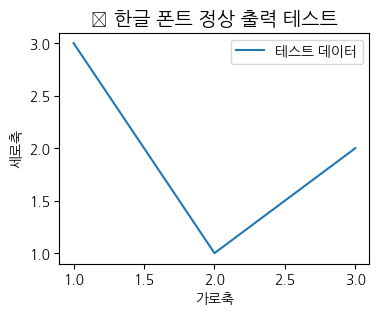

In [15]:
# ============================================
# ✅ 1️⃣ 나눔고딕 폰트 직접 설치
# ============================================
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm -rf ~/.cache/matplotlib

# ============================================
# ✅ 2️⃣ matplotlib에 폰트 재등록
# ============================================
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import os

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

if not os.path.exists(font_path):
    print("❌ 나눔고딕 폰트가 설치되지 않았습니다.")
else:
    print(f"✅ 나눔고딕 폰트 경로 확인됨: {font_path}")

    # 폰트 매니저에 추가
    fm.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False

    # 등록된 폰트 확인
    available_fonts = [f.name for f in fm.fontManager.ttflist if 'Nanum' in f.name]
    print("📋 사용 가능한 한글 폰트 목록:", available_fonts)

# ============================================
# ✅ 3️⃣ 테스트 그래프
# ============================================
plt.figure(figsize=(4,3))
plt.title("🎵 한글 폰트 정상 출력 테스트", fontsize=14)
plt.plot([1,2,3],[3,1,2], label="테스트 데이터")
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.legend()
plt.show()

Device set to use cuda:0


📟 사용 장치: GPU


Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[1/5] '오늘 밤 너와 나' 생성 중...
오늘 밤 너와 나
날 새롭게 하는
따뜻하게 만드는
니 눈빛 니 미소
영원히 담아둘게
너로 가득한 맘
널 닮아가는 나도
날 위한 선물
꿈보다 더 아름다운
서로의 품에서
끝 없는 밤을 걷자
나의 모든 날들을 다 주고싶어
내 이 맘을 모두 전하고 싶어
잠들지 못한
푸른 바람들
이
오늘 밤 너와 나
전부 그대 꺼니까
그대는 걱정 말아요
이제 나만 믿어요



오늘 하루 어땠었나요
많이 힘들었어요
쉬지 않고 달려왔던 길에서
나와 함께 쉬어가요
그냥 아무런 준비도 없이
떠나볼까요
평범해도 좋으니까
우리 함께 가요
Du D
오늘 밤 너와 나
날 새롭게 하는
따뜻하게 만드는
니 눈빛 니 미소
영원히 담아둘게
너로 가득한 맘
널 닮아가는 나 모든 날들이
세상 모두가 변한다 해도
변함없이 너를 사랑해
너의 마음을 너에게 알까
지금 이 순간 너의 손을 잡은 듯
아직은 너무연한 내 맘에
사랑하지 않아도 돼
[2/5] '사랑' 생성 중...
사랑해
내가 너를 사랑해도
네가 날 안 사랑하게 할걸



아득한 시간 속에 아직
우리 사랑이 남아있을까
멀어지던 그날의 너와 나
마주 보던 모습 그대로
내 사랑이 고마워
운명 같은 밤 너의 곁에
두고 온 기억들을
늘 그리워하며 보내
사랑한 거야
내 마지막 숨결도 너일거야 사랑해



Cos ah ao
I’m in the stars tonight
So watch me bring the fire
and set the night alight by my way
Just dre
사랑했어
다신 나 같은 사람 만나지 마요
혹시 찾아가도 두 번 다시
나를 허락해 주지 마
그댄 여리고 너무 착해서
싫단 말도 잘 못하는데
많이 부족한 나를 사랑한 그대
이거면 됐어요
더 이상은 그대 불행하지 않도록
나 이쯤에서 없어지는 게
정말 사랑할 수 없는 일
너무 투명
[3/5] '바닷가에서' 생성 중...
바닷가에서 혼자 춤을 춰
정해진 안녕 따위는 없어
아름다웠던 그 기억에서 만나

우리는 서로를 베고 누워
슬프지 않은 이야

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


해변에서 혼자
한잔 할까
Drink like a lil spotlight
너에게 한잔할까 Drinping in the deep
Shining through the city
with a friend join the stars
I’m in trouble life
But this is
해변에서
너와 걷고 싶어져서
내일 많이 바쁘지 않으면
혹시 나랑 같이 걸을래
많이 어색한가 봐
자꾸 딴 델 보고
널 닮은 별만 바라봐
싱그럽게 불어오는 바람에
넌 나를 빛나게 해
매일 다른 누구 아닌 너와 나
세상을 가진 것 마냥
사랑해 너를 사랑해
해변에서
나와 함께 춤추고 싶어
색색의 옷들과 예쁜 액세서리
oh baby
흐르는 저 음악이
내 맘을 설레게 하지
I feel the disco rhythm in my body (yeah)
다른 아무것도 생각하진 마
you got me looking for attention
[5/5] '함께하는' 생성 중...
함께하는
너의 모든 순간 그게
나였으면 좋겠다
생각만 해도 가슴이 차올라
나는 온통 너로
보고 있으면 왠지 꿈처럼 아득한 것
몇 광년 동안 날 향해 날아온 별빛
또 지금의 너
거기 있어줘서 그걸로 충분해
니가 나의 모든 걸 뺏어갔어도
모두가 내 꿈에 바리케이드를 쳐
함께하는 나
나보다 더 좋은 사람 만나서
이젠 내겐 너뿐이라고



Look at you 넌 못 감당해 날
Ya took off hook
기분은 Coke like brr
Bring back
그냥 꽉 눌러 모두 다 looky
내가 추는


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


함께하는 나
나보다 나를 더 아껴주는
그 사람 곁에 있는 지금 순간 순간이
영원 했으면 해
갈게 바람이 좋은 날에
햇살 눈부신 어떤 날에 너에게로
처음 내게 왔던 그날처럼
모든 날 모든 순간 함께해



Look how all the tables
How do
[1/5] '오늘 밤 너와 나' 생성 중...
오늘 밤 너와 나
가라앉은 가슴
널 향해 팔 벌려
오늘도 힘겹게 버틴 걸
난 참 기억력도 좋지 않은데
왜 너에 관한 건
그 사소한 추억들까지도 생각이 나는지
너를 잊을 순 없지만 붙잡고 싶지만
이별 앞에서 할 수 있는 건 오직 하나
영원한 행복을 꿈꾸지만 그게
아직 어색하지만
오늘 밤 너와 나
전부 그대 꺼니까
그대는 걱정 말아요
이제 나만 믿어요



밤하늘의 별을 따서 너에게 줄래
너는 내가 사랑하니까
더 소중하니깐
오직 너 아니면 안 된다고
외치고 싶어 그저
내 곁에만 있어줘
떠나지 말아줘 이제부터
혼자가 아니야
오늘 밤 너와 나
My life's shining like a VVS VvS
내 삶은 빛나 V VSVV
보란 듯 나와 TV에
Now you see me babe
 내 삶은 온통 너 ya
사소한 게 사소하지 않게
만들어버린 너라는 별
하나부터 열까지 모든 게
[2/5] '사랑' 생성 중...
사랑해
사랑해 사랑해서
우린 영원히 사랑할 거야



Look how all the tables
Don’t need to talk thetalted
‘Cause we don't got this on lock yeah
This
사랑해



너를 사랑하고 있어
자기야 날 사랑해주면 안 될까
말처럼 쉽지는 않은 걸 알지만
세게 날 안아주면 안될까 (날 안아주면)
오늘따라 세상이 무섭단 말이야
잠깐 인공호흡을 해주라
왠지 숨이 잘 안 쉬어져서 난
사랑해



You’re so yummy yunmmy,
a’ll get you stop me,
you want someone
What’s your ETA, why
Every time is yet now
Right here
[

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


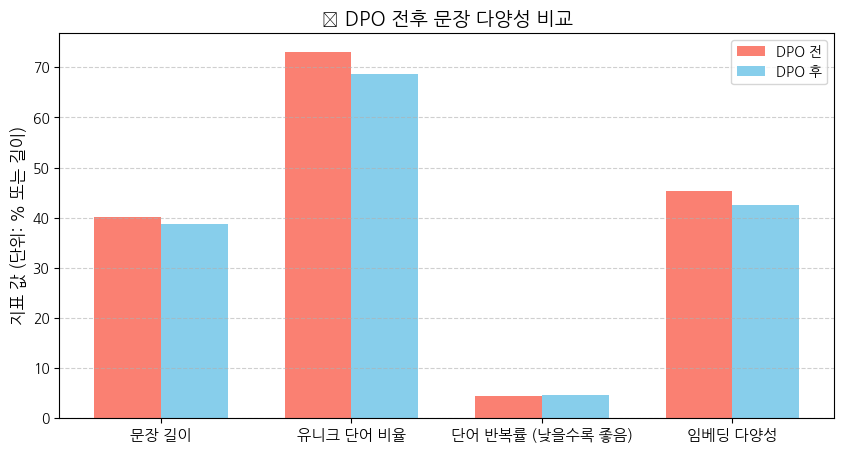

=== 📊 문장 다양성 지표 요약 ===
▶ 평균 문장 길이: DPO 전 40.20 → DPO 후 38.73
▶ 유니크 단어 비율: DPO 전 73.13% → DPO 후 68.67%
▶ 단어 반복률: DPO 전 4.47% → DPO 후 4.56%
▶ 임베딩 다양성 점수: DPO 전 45.32% → DPO 후 42.52%


In [16]:

# ================================================
# ✅ 기본 라이브러리 임포트
# ================================================
import torch
from transformers import pipeline, AutoTokenizer
from sentence_transformers import SentenceTransformer, util
import numpy as np
import re

# ================================================
# 1️⃣ 모델 경로 및 로드 / 기존 모델과 기존 + DPO 적용 모델.
# ================================================
model_before_path = "./kpop-kogpt2-finetuned-v2"
model_after_path = "./kpop-kogpt2-dpo"

device = 0 if torch.cuda.is_available() else -1
print(f"📟 사용 장치: {'GPU' if device==0 else 'CPU'}")

generator_before = pipeline("text-generation", model=model_before_path, tokenizer=model_before_path, device=device)
generator_after = pipeline("text-generation", model=model_after_path, tokenizer=model_after_path, device=device)
tokenizer = AutoTokenizer.from_pretrained(model_before_path)

# ================================================
# 3️⃣ 문장 생성 함수
# ================================================
def generate_sentences(generator, prompts, num=3):
    results = []
    for i, p in enumerate(prompts):
        print(f"[{i+1}/{len(prompts)}] '{p}' 생성 중...")
        for _ in range(num):
            out = generator(
                p,
                max_new_tokens=80,
                do_sample=True,
                top_k=50,
                top_p=0.9,
                truncation=True,
                no_repeat_ngram_size=2
            )[0]['generated_text'].replace("<|endoftext|>", "").strip()
            print(out)
            results.append(out)
    return results

sentences_before = generate_sentences(generator_before, prompts)
sentences_after = generate_sentences(generator_after, prompts)

# ================================================
# 4️⃣ 평가 함수 정의
# ================================================
def clean_text(text):
    text = re.sub(r"[^ㄱ-ㅎ가-힣a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text.strip())
    return text

def calc_diversity(sentences):
    lengths = [len(s.split()) for s in sentences]
    tokens = [t for s in sentences for t in s.split()]
    unique_tokens = len(set(tokens))
    total_tokens = len(tokens)
    unique_ratio = unique_tokens / total_tokens if total_tokens else 0

    # 반복 단어 비율 (문장별 중복 단어 비율 평균)
    repeats = [len(s.split()) - len(set(s.split())) for s in sentences]
    repeat_rate = np.mean([
        repeats[i] / len(s.split()) if len(s.split()) > 0 else 0
        for i, s in enumerate(sentences)
    ])

    return {
        "avg_length": np.mean(lengths),
        "unique_ratio": unique_ratio,
        "repeat_rate": repeat_rate
    }

# ================================================
# 5️⃣ 텍스트 정제 및 지표 계산
# ================================================
sentences_before = [clean_text(s) for s in sentences_before]
sentences_after = [clean_text(s) for s in sentences_after]

div_before = calc_diversity(sentences_before)
div_after = calc_diversity(sentences_after)

# ================================================
# 6️⃣ 임베딩 다양성 계산 (문장 간 유사도 기반)
# ================================================
embedder = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

emb_before = embedder.encode(sentences_before, convert_to_tensor=True)
emb_after = embedder.encode(sentences_after, convert_to_tensor=True)

sim_before = util.pytorch_cos_sim(emb_before, emb_before).mean().item()
sim_after = util.pytorch_cos_sim(emb_after, emb_after).mean().item()

diversity_score_before = 1 - sim_before
diversity_score_after = 1 - sim_after

# ================================================
# 7️⃣ 시각화
# ================================================
labels = ["문장 길이", "유니크 단어 비율", "단어 반복률 (낮을수록 좋음)", "임베딩 다양성"]
before_scores = [
    div_before["avg_length"],
    div_before["unique_ratio"] * 100,
    div_before["repeat_rate"] * 100,
    diversity_score_before * 100
]
after_scores = [
    div_after["avg_length"],
    div_after["unique_ratio"] * 100,
    div_after["repeat_rate"] * 100,
    diversity_score_after * 100
]

x = np.arange(len(labels))
bar_width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - bar_width/2, before_scores, bar_width, label="DPO 전", color="salmon")
plt.bar(x + bar_width/2, after_scores, bar_width, label="DPO 후", color="skyblue")
plt.xticks(x, labels, fontsize=11)
plt.ylabel("지표 값 (단위: % 또는 길이)", fontsize=12)
plt.title("🎵 DPO 전후 문장 다양성 비교", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

# ================================================
# 8️⃣ 수치 요약 출력
# ================================================
print("=== 📊 문장 다양성 지표 요약 ===")
print(f"▶ 평균 문장 길이: DPO 전 {div_before['avg_length']:.2f} → DPO 후 {div_after['avg_length']:.2f}")
print(f"▶ 유니크 단어 비율: DPO 전 {div_before['unique_ratio']*100:.2f}% → DPO 후 {div_after['unique_ratio']*100:.2f}%")
print(f"▶ 단어 반복률: DPO 전 {div_before['repeat_rate']*100:.2f}% → DPO 후 {div_after['repeat_rate']*100:.2f}%")
print(f"▶ 임베딩 다양성 점수: DPO 전 {diversity_score_before*100:.2f}% → DPO 후 {diversity_score_after*100:.2f}%")
